[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-01-01   963.658020  1003.080017   958.698975   998.325012   998.325012   
2017-01-02   998.617004  1031.390015   996.702026  1021.750000  1021.750000   
2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  1043.839966   
2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  1154.729980   
2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  1013.380005   

               Volume  
Date                   
2017-01-01  147775008  
2017-01-02  222184992  
2017-01-03  185168000  
2017-01-04  344945984  
2017-01-05  510199008  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003  320.884003   
2017-11-10  320.670990  324.717987  294.541992  299.2529

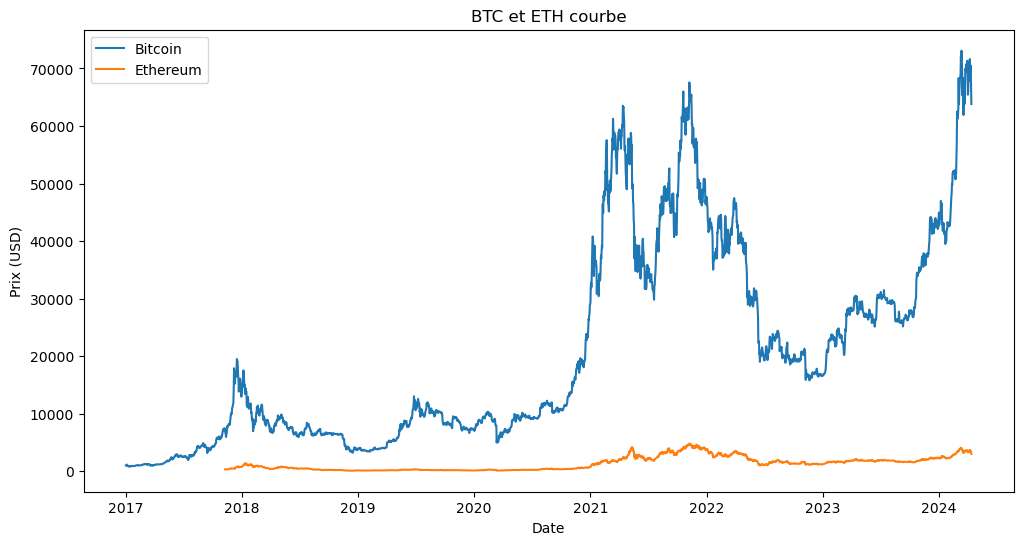

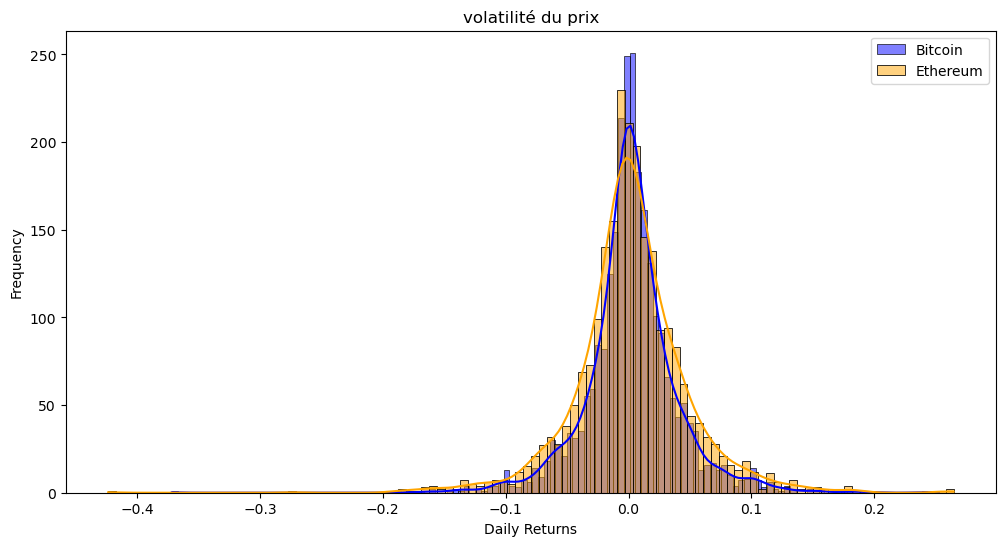

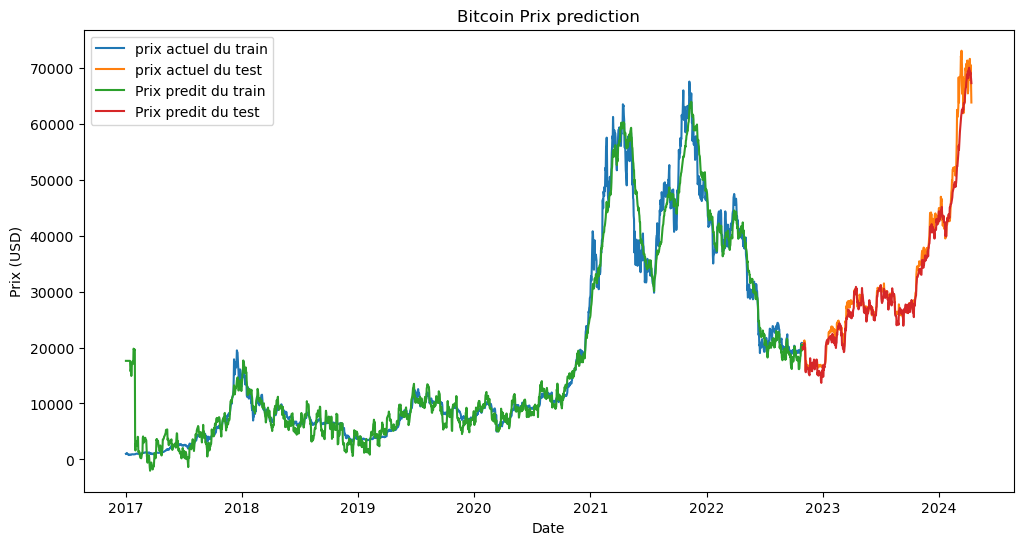

In [5]:
##Projet prediction crypto entrainement
#Installation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
#Data BTC et ETH
start_date = '2017-01-01'
end_date = '2024-04-14'

btc_data = yf.download('BTC-USD', start=start_date, end=end_date)
eth_data = yf.download('ETH-USD', start=start_date, end=end_date)

print(btc_data.head())
print(eth_data.head())

##Courbe des prix 
plt.figure(figsize=(12, 6)) #Plot les graphiques
plt.plot(btc_data['Close'], label='Bitcoin') #Close pour prix de fermeture
plt.plot(eth_data['Close'], label='Ethereum')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.title('BTC et ETH courbe')
plt.legend()


## Volatiltié
btc_returns = btc_data['Close'].pct_change().dropna()  #pct_change = calcul rendement quotidien
eth_returns = eth_data['Close'].pct_change().dropna()
plt.figure(figsize=(12, 6)) #plot les graphiques
sns.histplot(btc_returns, kde=True, color='blue', label='Bitcoin') 
sns.histplot(eth_returns, kde=True, color='orange', label='Ethereum')
plt.xlabel('Daily Returns') #Nommer les graphiques
plt.ylabel('Frequency')
plt.title('volatilité du prix')
plt.legend() #afficher la légende

##Prédiction :
#Moyenne mobile (Cout terme avec 30j, long terme avec 365)
btc_data['MA_30'] = btc_data['Close'].rolling(window=30).mean()
btc_data['MA_365'] = btc_data['Close'].rolling(window=365).mean()
eth_data['MA_30'] = eth_data['Close'].rolling(window=30).mean()
eth_data['MA_365'] = eth_data['Close'].rolling(window=365).mean()

#RSI relative strengh index) (= indice force relative)
#Le RSI est un oscillateur qui varie entre 0 et 100 et est typiquement utilisé pour identifier les conditions de surachat ou de survente d'un actif
#Le RSI est calculé sur la base des gains et des pertes moyennes sur une période déterminée, habituellement 14 jours. 
#On calcule d'abord la moyenne des gains et la moyenne des pertes sur cette période, puis on applique la formule
#RSi > 70 : potentiel surachat = possible correction a la baisse
#RSi < 30 : Potentielle survente = possible rebond du prix

def calculate_rsi(data, window=14):
    delta = data.diff() #Calcul du changement du prix d'un jour à l'autre
    up = delta.clip(lower=0) #Gain (= on garde quand delta positif)
    down = -delta.clip(upper=0) #perte (= on garde quand delta négatif puis on les convertie en positif pour avoir la valeur des pertes)
    avg_gain = up.rolling(window).mean() #Calcul moyenne glissante sur 14 jours
    avg_loss = down.rolling(window).mean()
    rs = avg_gain / avg_loss #Calcul moyenne des gains/moyenne des pertes
    rsi = 100 - (100 / (1 + rs)) #Calcul de l'indice
    return rsi

btc_data['RSI'] = calculate_rsi(btc_data['Close'])
eth_data['RSI'] = calculate_rsi(eth_data['Close'])


##Prediction
#Regression linéaire 

split_index = int(len(btc_data) * 0.8) #On separe la base de donné en train et test
train_data = btc_data[:split_index]
test_data = btc_data[split_index:]

#Modele :
features = ['MA_30', 'MA_365', 'RSI']
X_train = train_data[features].values #Base d'entrainement
y_train = train_data['Close'].values #Ce que l'on veut predire (prix de fermutre)
X_test = test_data[features].values
y_test = test_data['Close'].values #Pour tester le modèle
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

imputer = SimpleImputer(strategy='mean') #Gestion des NA (remplacé par la moyenne)
X_train = imputer.fit_transform(X_train) #On applique la moyenne pour X_train
X_test = imputer.transform(X_test) #On applique la moyenne de X_train pour X_test pour ne pas fausser 

model = LinearRegression()
model.fit(X_train, y_train) #Creation du modèle sur La base de données Train

train_predictions = model.predict(X_train) #test de la prévision sur les données deja vu
test_predictions = model.predict(X_test) #test de la prévision sur des données nouvelles
#evaluation du modèle
#Calcul du RMSE : au plus il est bas, meilleur est le modèle
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions)) #Calcul RMSE données Train
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions)) #Idem pour test
print(f'Train RMSE: {train_rmse:.2f}') #Print du resultat
print(f'Test RMSE: {test_rmse:.2f}')

#verification des prédictions :
#On regarde les prédictions du modèle, contre les valeurs réelles pour voir si cela correspond
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, y_train, label='prix actuel du train') #Graphique des vrais prix
plt.plot(test_data.index, y_test, label='prix actuel du test')
plt.plot(train_data.index, train_predictions, label='Prix predit du train') #Graphique des prix prédits
plt.plot(test_data.index, test_predictions, label='Prix predit du test')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.title('Bitcoin Prix prediction')
plt.legend()



Conclusion :
Le modèle semble bien prédire les vrais données, le RMSE du test est plus bas que celui du train, ce qui est bon signe
De plus, les prix des cryptos étant plutot volatile, ce RMSE est correct pour ce genre de donnée.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


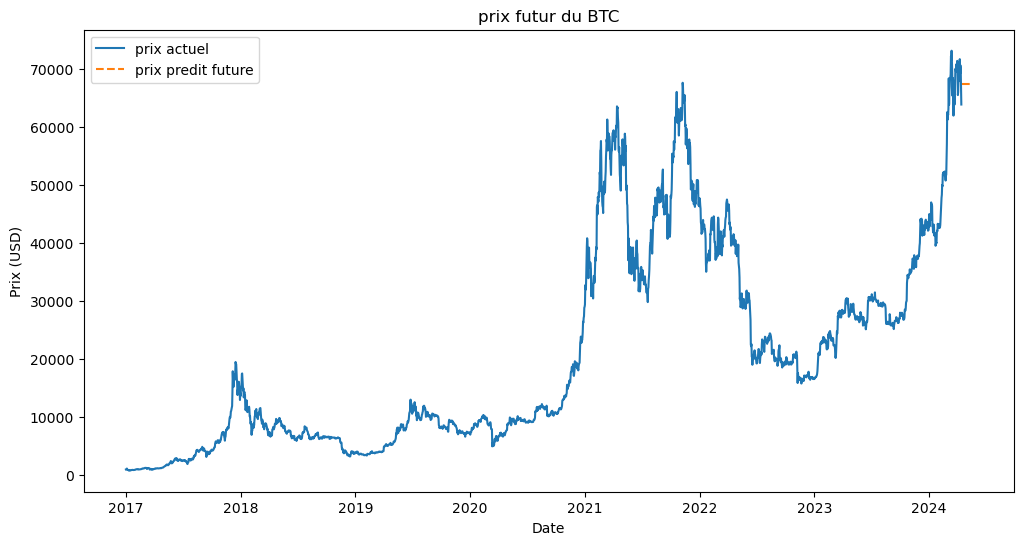

In [7]:
##Prediction futures
from datetime import datetime

last_date = btc_data.index[-1] #derniere date

end_prediction_date = datetime(2024, 5, 15) #date cible

days_to_predict = (end_prediction_date - last_date).days #nombre de jour à prédire
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict, freq='D') #Creation d'une "data_range" contenant les futures dates

future_data = pd.DataFrame(index=future_dates) #creation d'un data frame pour y ranger les futures MA, RSI etc
future_data['MA_30'] = btc_data['MA_30'].iloc[-1] #On range dans ce dataframe les données
future_data['MA_365'] = btc_data['MA_365'].iloc[-1]
future_data['RSI'] = btc_data['RSI'].iloc[-1]
#Nb : iloc[-1] sert a prendre la derniere variable 

#Prediction
future_features = future_data[['MA_30', 'MA_365', 'RSI']] #On selectionne les données de notre dataframe
future_features = imputer.transform(future_features)  # On traite les NA si besoin (de la meme facon que précédément)

future_predictions = model.predict(future_features) #prediction du prix avec notre modèle précédent
predictions_df = pd.DataFrame(future_predictions, index=future_dates, columns=['prix predit']) #
#Graphique
plt.figure(figsize=(12, 6))
plt.plot(btc_data['Close'], label='prix actuel')
plt.plot(predictions_df['prix predit'], label='prix predit future', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.title('prix futur du BTC')
plt.legend()
plt.show()


Conclusion : On peut voir que la prédiction ici n'est pas correcte.
Il serait interessant d'utiliser un meilleur modèle, avec des données supplémentaires.
Au vu de nos données, il pourrait être également intéréssant de seulement prédire si le prix va monter ou baisser pour le jour suivant (y=1 pour une hausse, y=0 pour une baisse), grâce aunb modèle logit par exemple